# Load dataset

In [2]:
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow import data

2022-09-22 13:44:16.750351: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-22 13:44:17.324100: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-22 13:44:17.324146: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-09-22 13:44:17.406775: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-22 13:44:19.056271: W tensorflow/stream_executor/platform/de

In [3]:
with open("data_path.txt", "r") as f:
    data_path = f.read()

In [4]:
def load_images(data_path: str, batch_size: int, size: tuple, split: tuple):
    train_ds = image_dataset_from_directory(
        data_path,
        validation_split=split[0],
        subset="training",
        seed=123,
        image_size=size,
        batch_size=batch_size)
    
    val_ds = image_dataset_from_directory(
        data_path,
        validation_split=split[1],
        subset="validation",
        seed=123,
        image_size=size,
        batch_size=batch_size)

    # My kernel crashes if I use this perf optimisation advised by TF.
    # AUTOTUNE = data.AUTOTUNE
    # train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
    # val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
    
    return (train_ds, val_ds)

# Modelisation

In [5]:
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

# PLot performances
import matplotlib.pyplot as plt

In [6]:
num_classes = 1

## NN

In [7]:
batch_size = 32
height = 28
width = 28
size = (height, width)
split = (0.9, 0.05)

In [14]:
train_ds ,val_ds = load_images(data_path, batch_size, size, split)

Found 25000 files belonging to 2 classes.
Using 2500 files for training.


2022-09-22 13:02:10.405503: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-22 13:02:10.407881: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-22 13:02:10.408167: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-09-22 13:02:10.408364: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-09-22 13:02:10.408550: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

Found 25000 files belonging to 2 classes.
Using 1250 files for validation.


In [15]:
# https://www.tensorflow.org/tutorials/keras/classification
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(height, width, 3)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(num_classes)
])

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2352)              0         
                                                                 
 dense (Dense)               (None, 128)               301184    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 301,313
Trainable params: 301,313
Non-trainable params: 0
_________________________________________________________________


### Training

In [13]:
epochs = 10
callback = EarlyStopping(monitor='val_loss', patience=3)

In [17]:
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=callback)

Epoch 1/10
79/79 [==============================] - 25s 294ms/step - loss: 59.3431 - binary_accuracy: 0.5056 - val_loss: 12.9481 - val_binary_accuracy: 0.5200
Epoch 2/10
79/79 [==============================] - 0s 3ms/step - loss: 9.4202 - binary_accuracy: 0.5252 - val_loss: 5.1489 - val_binary_accuracy: 0.5352
Epoch 3/10
79/79 [==============================] - 0s 2ms/step - loss: 6.8980 - binary_accuracy: 0.5456 - val_loss: 12.1212 - val_binary_accuracy: 0.5128
Epoch 4/10
79/79 [==============================] - 0s 2ms/step - loss: 7.2762 - binary_accuracy: 0.5544 - val_loss: 5.4606 - val_binary_accuracy: 0.5400
Epoch 5/10
79/79 [==============================] - 0s 2ms/step - loss: 4.0574 - binary_accuracy: 0.5892 - val_loss: 3.7967 - val_binary_accuracy: 0.5576
Epoch 6/10
79/79 [==============================] - 0s 2ms/step - loss: 3.9869 - binary_accuracy: 0.6032 - val_loss: 3.9530 - val_binary_accuracy: 0.5568
Epoch 7/10
79/79 [==============================] - 0s 2ms/step - loss

### Performances

In [8]:
def plot_history(history) -> None:
    acc = history.history['binary_accuracy']
    val_acc = history.history['val_binary_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

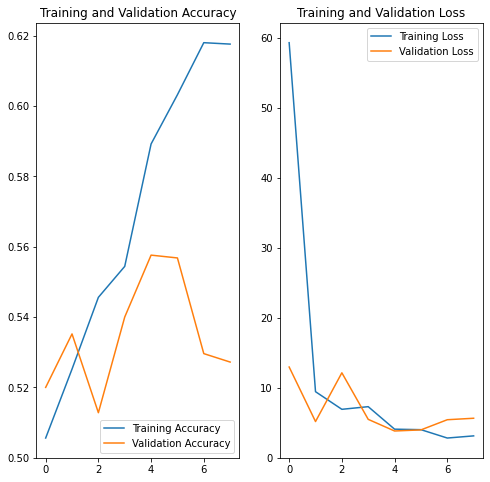

In [19]:
plot_history(history)

## CNN

In [9]:
height = 224
width = 224
size = (height, width)

In [10]:
train_ds ,val_ds = load_images(data_path, batch_size, size, split)

Found 25000 files belonging to 2 classes.
Using 2500 files for training.


2022-09-22 13:44:37.435717: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-22 13:44:37.436292: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-22 13:44:37.436522: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-09-22 13:44:37.436941: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-09-22 13:44:37.437371: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

Found 25000 files belonging to 2 classes.
Using 1250 files for validation.


In [11]:
# https://www.tensorflow.org/tutorials/images/classification

model = keras.Sequential([
  keras.layers.Rescaling(1./255, input_shape=(height, width, 3)),
  keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(num_classes)])

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        1

### Training and performances

In [14]:
# For time reason, I train on only 3 epochs.
history = model.fit(train_ds, epochs=3, validation_data=val_ds, callbacks=callback)

Epoch 1/3
79/79 [==============================] - 66s 806ms/step - loss: 0.7625 - binary_accuracy: 0.4920 - val_loss: 0.6879 - val_binary_accuracy: 0.4976
Epoch 2/3
48/79 [=================>............] - ETA: 24s - loss: 0.6880 - binary_accuracy: 0.5026

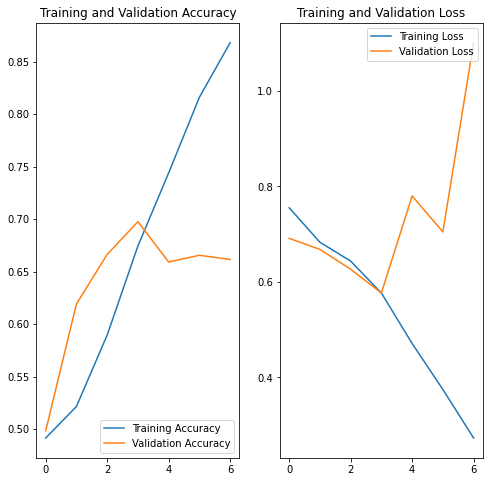

In [ ]:
plot_history(history)

## ResNet50

In [ ]:
base_model = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)
base_model.trainable = False

inputs = keras.Input(shape=(height, width, 3))
x = preprocess_input(inputs)
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(num_classes)(x)
model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

model.summary()

2022-09-20 08:50:19.385599: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-20 08:50:19.385765: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-20 08:50:19.385824: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-09-20 08:50:19.385870: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-09-20 08:50:19.385916: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_____________________________________________

### Training and performances

In [ ]:
# For time reason, I train on only 3 epochs.
history = model.fit(train_ds, epochs=3, validation_data=val_ds, callbacks=callback)

Epoch 1/3
79/79 [==============================] - ETA: 0s - loss: 0.2057 - binary_accuracy: 0.9160

: 

: 

In [ ]:
plot_history(history)

# References

* https://github.com/PacktPublishing/Learning-Computer-Vision-with-TensorFlow
* https://www.tensorflow.org/tutorials/keras/classification
* https://www.tensorflow.org/tutorials/images/classification
* https://keras.io/guides/transfer_learning/
* https://www.kaggle.com/code/ryanholbrook/the-convolutional-classifier#Introduction
* https://www.kaggle.com/code/dansbecker/transfer-learning